# Exploring Shuffling Methods

I play a lot of card games, and am always worried about how well I shuffle. Whenever I deal up a new hand and get what seems like an unlikely sequence of cards, I can't help but question whether I've shuffled adequately. Particularly when playing a TCG and I've first constructed a deck, I have a lot of paranoia about shuffling properly so I don't end up with a game full of awkward hands. 

I'm going to explore different methods of shuffling and how much shuffling is required to get a truly randomized distribution of cards. Here I'm going to do this through simulation. In future notebooks I may actually shuffle up some cards physically to see how effectively I can put theory into practice.

I'm sure other people have done this kind of thing, and a quick Google or YouTube search could give me all of the answers I'm looking for. But it seems like fun to answer myself, so here I go.

In [1]:
import sys

import numpy as np
%matplotlib widget 
from matplotlib import pyplot as pl

sys.path.append('../src/')
import shufflers as s

I'm going to run my analysis against a 60 card deck, common in several TCGs including Flesh and Blood's Classic Constructed format, which is what I'm playing most these days.

Let's start with an unshuffled deck, which I'll represent as an array of integers representing the index of each card.

In [2]:
fresh_deck = np.arange(60)

In [3]:
fresh_deck

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

I've implemented several shuffler classes (see accompanying module for details), each with a `shuffle` method that take in a deck, shuffles it *once* according to the shuffling strategy implemented in the class, and returns a new array with the shuffled cards.

In [4]:
shuffler = s.IdealShuffler()
shuffler.shuffle(fresh_deck)

array([48, 47, 37, 58, 20, 28,  7,  6, 25, 13,  4, 59, 50, 36, 41,  1, 49,
       57,  3, 17,  9, 46, 14, 44, 55, 43, 11, 52, 21, 32, 38, 29,  0, 39,
       15, 12,  8, 34, 35, 33,  5, 22, 16, 42, 19, 45, 23, 24, 54,  2, 26,
       56, 30, 10, 18, 31, 51, 27, 53, 40])

I'm not sure the best way to measure how well a deck has been shuffled, but one way that I thought of is to look at the resulting distance between two cards that were next to one another initially. For example, in the `fresh_deck` above, cards 0 and 1 start next to one another. After shuffling, we can measure the absolute difference between the positions of cards 0 and 1. For a perfectly shuffled deck, we would expect this distance to follow a specific distribution. What is that distribution?

The smallest distance between cards is 1 and the largest is the size of the deck minus 1 (59 in this case).

I would expect a higher probability of measuring a small distance than a large distance because there are more configurations where short distances are possible than large distances. Consider the following example for a 5 card deck.

There are 8 possible configurations for cards 0 and 1 to be 1 position apart.
```
0 1 X X X
X 0 1 X X
X X 0 1 X
X X X 0 1
1 0 X X X
X 1 0 X X
X X 1 0 X
X X X 1 0
```

There are 6 possible configurations for cards 0 and 1 to be 2 positions apart.
```
0 X 1 X X
X 0 X 1 X
X X 0 X 1
1 X 0 X X
X 1 X 0 X
X X 1 X 0
```

There are 4 possible configurations for cards 0 and 1 to be 3 positions apart.
```
0 X X 1 X
X 0 X X 1
1 X X 0 X
X 1 X X 0
```

There are 2 possible configurations for cards 0 and 1 to be 4 positions apart.
```
0 X X X 1
1 X X X 0
```


So the probability distribution for distance between two cards would look like

```
*
* *
* * *
* * * *
1 2 3 4
```

Counting out different configurations, for a perfectly randomized deck we should expect a linear decrease in probability from the minimum distance of 1 to the maximum given that for each larger distance there are fewer possible configurations where two cards can be separated by the given distance.

Here I've written a function to simulate shuffling a deck up to `n_shuffles` number of times for a given shuffling strategy. We can simulate shuffling the deck over an over, `n_sims` times, and record the deck state after each shuffle for each trial. We'll measure the distance between two initially consecutive cards throughout to assess deck randomness. The function returns a dictionary keyed on the shuffle number that stores an array of distances between the given `marked_card` and its initial neighbor for all trials.

In [5]:
def simulate_shuffling(starting_deck, shuffler_class, n_sims=10000, n_shuffles=30, marked_card=0, **shuffler_kwargs):
    
    distances = {i+1: [] for i in range(n_shuffles)}
    
    for i in range(n_sims):
        deck = np.array(starting_deck)
        shuffler = shuffler_class(**shuffler_kwargs)
        for j in range(n_shuffles):
            shuffled_deck = shuffler.shuffle(deck)
            deck = shuffled_deck
            
            i0 = np.where(shuffled_deck==marked_card)[0][0]
            i1 = np.where(shuffled_deck==(marked_card + 1))[0][0]
            dist = abs(i1-i0)
            distances[j+1].append(dist)
            

    return distances

I've got a couple of methods here to visualize how well shuffled the deck is after N shuffles. We can look at the histogram of distances between our marked card and its neighbor after N shuffles. We can also look at quantiles of the distribution over N shuffles to more easily see how the distribution evolves.

In [58]:
def plot_histograms(distances, true_x=None, true_dist=None): 
    
    keys=[1, 2, 3, 5, 8, 13]
    
    f = pl.figure(figsize=(9, 9))
    for i,k in enumerate(keys):
        pl.subplot(320 + i + 1) 
        pl.hist(distances[k], bins=np.arange(1, 60))
        pl.title(f"{k} Shuffles")
        if true_x is not None:
            pl.plot(true_x, true_dist * len(distances[k]), '--k', alpha=0.5)
    pl.tight_layout();

In [7]:
def plot_sim_summary(sim_results, ideal_sim_results=None):

    stats = {"mean": [], "median": [], "5th": [], "25th": [], "75th": [], "95th": []}
    n_shuffles = sorted(sim_results.keys())
    for shuffle_num in n_shuffles:
        stats["median"].append(np.median(sim_results[shuffle_num]))
        stats["mean"].append(np.mean(sim_results[shuffle_num]))
        for q, q_label in zip([0.05, 0.25, 0.75, 0.95], ["5th", "25th", "75th", "95th"]):
            stats[q_label].append(np.quantile(sim_results[shuffle_num], q))

    pl.figure()
    pl.plot(n_shuffles, stats["mean"], "r", alpha=0.7, label='Mean')
    pl.plot(n_shuffles, stats["5th"], ":r", alpha=0.7, label='5th')
    pl.plot(n_shuffles, stats["25th"], "--r", alpha=0.7, label='25th')
    pl.plot(n_shuffles, stats["75th"], "--r", alpha=0.7, label='75th')
    pl.plot(n_shuffles, stats["95th"], ":r", alpha=0.7, label='95th')
    
    pl.xlabel("Number of shuffles")
    pl.ylabel("Distance between adjacent cards")
    
    if ideal_sim_results is not None:
        pl.axhline(ideal_stats["mean"], c='k', alpha=0.7)
        pl.axhline(ideal_stats["25th"], ls='--', c='k', alpha=0.7)
        pl.axhline(ideal_stats["75th"], ls='--', c='k', alpha=0.7)
        pl.axhline(ideal_stats["5th"], ls=':', c='k', alpha=0.7)
        pl.axhline(ideal_stats["95th"], ls=':', c='k', alpha=0.7)
    pl.legend(loc=0);
    
    return stats

This function computes the probability that two cards will be n spaces apart in the deck. 

In [31]:
def ideal_card_separation_distribution(deck): 
    N = len(deck)
    x = np.arange(1, N)
    p = (N - x) * 2
    p = p / sum(p)
    return p

**TODO** Add in ideal card distribution to calculate expected mean and quartiles, add a reference line on the histograms, etc. Can I use the KL divergence to compare distributions and figure out when we've really hit true randomness? Would be helpful to know if the distribution of hand shuffling matches simulations perhaps.

In [32]:
p = ideal_card_separation_distribution(fresh_deck)

In [51]:
def discrete_quantile(x, p, q):
    return x[np.where(np.cumsum(p) > q)[0][0]]

In [ ]:
x = (1 + np.arange(len(p)))

In [52]:
ideal_stats = {}
ideal_stats["mean"] = sum(p * (1 + np.arange(len(p)))) 
ideal_stats["5th"] = discrete_quantile(x, p, 0.05) 
ideal_stats["25th"] = discrete_quantile(x, p, 0.25) 
ideal_stats["75th"] = discrete_quantile(x, p, 0.75) 
ideal_stats["95th"] = discrete_quantile(x, p, 0.95) 

In [65]:
for k in ideal_stats:
    print(f"{k:>6}: {ideal_stats[k]:>6.2f}")

  mean:  20.33
   5th:   2.00
  25th:   8.00
  75th:  30.00
  95th:  47.00


<BarContainer object of 59 artists>

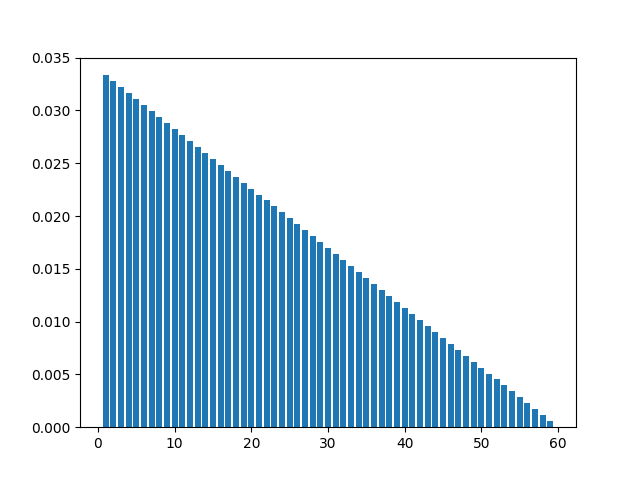

In [54]:
pl.figure()
pl.bar(x, p)

Let's look at a "perfect shuffler" that completely randomizes the deck each shuffle.

In [55]:
ideal_sim_results = simulate_shuffling(fresh_deck, s.IdealShuffler)

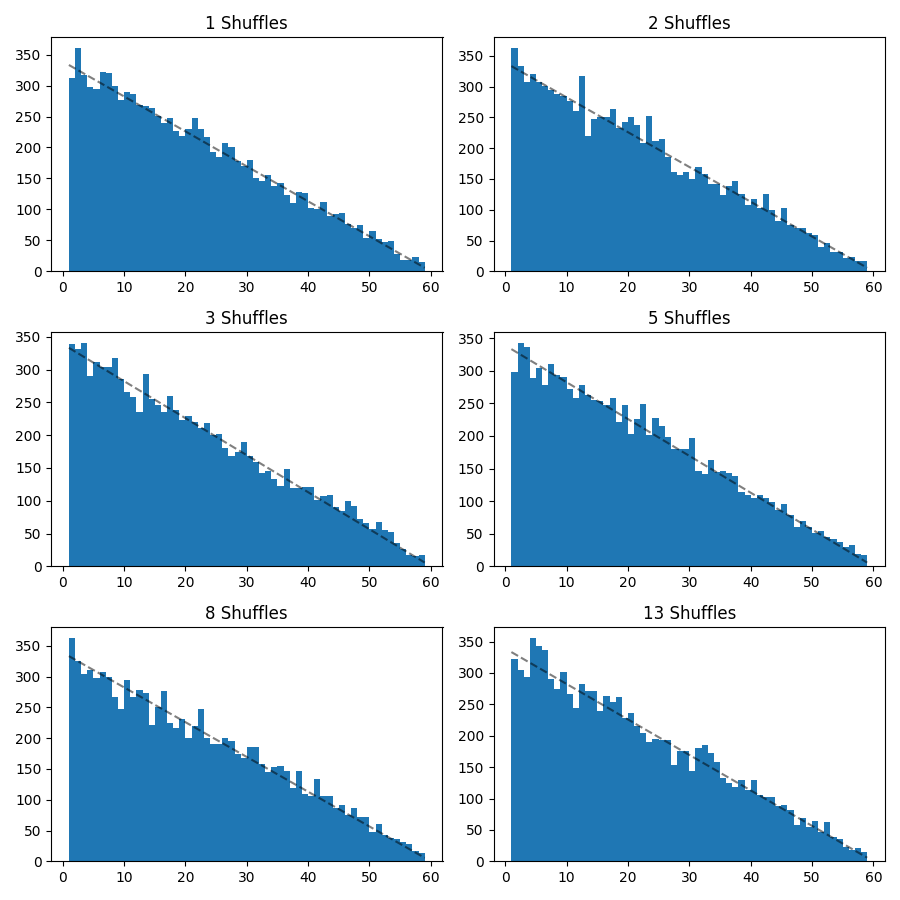

In [59]:
plot_histograms(ideal_sim_results, x, p)

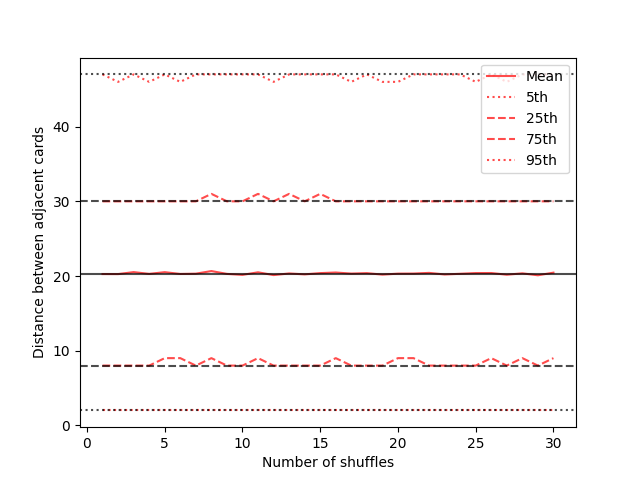

In [60]:
ideal_sim_stat_trends = plot_sim_summary(ideal_sim_results, ideal_sim_results)

We see the linear decrease in probability for each distance as expected. The average distance between two cards is 20.3 positions.

Of course, we get a perfectly randomized deck after just a single shuffle with this method, but we need a computer for this method of randomizing our cards.

Let's compare this to "riffle shuffling", where you cut a deck in half, then somewhat randomly interleave the cards from the two halves back together. I've simulated this with a random distribution of cards selected from one half before switching back to introduce cards from the other. The distribution I draw from is as follows:

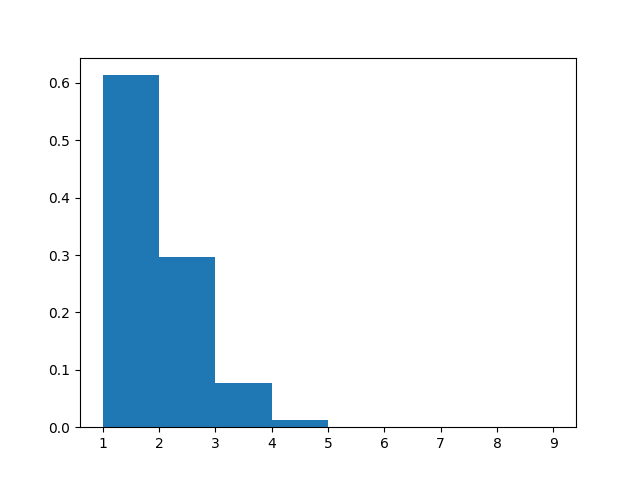

In [18]:
pl.figure()
pl.hist((np.random.poisson(0.5, size=10000) + 1), bins=np.arange(1, 10), density=True);

This distribution says that about 60% of the time we'll take one card from one half before switching back to take a card from the next half. Around 30% of the time we'll get two cards from one half before switching back to the other. Rarely we'll get a larger number of cards from one half in a row. 

Note that I'm not distinguishing between real "riffle shuffling" like you would do with a deck of playing cards and the type of "smash together" shuffling that TCG players more commonly do with a deck of sleeved cards. I think the mechanisms are pretty much the same unless I'm not thinking about it correctly.

In [66]:
riffle_sim_results = simulate_shuffling(fresh_deck, s.RiffleShuffler)

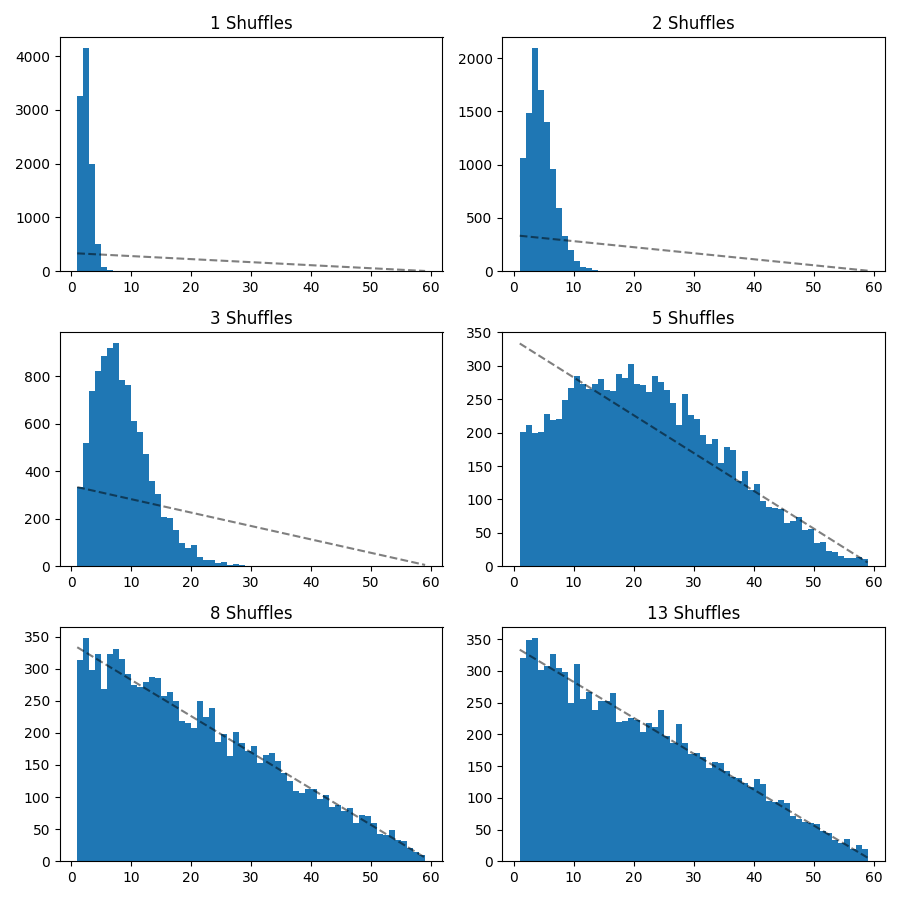

In [67]:
plot_histograms(riffle_sim_results, x, p)

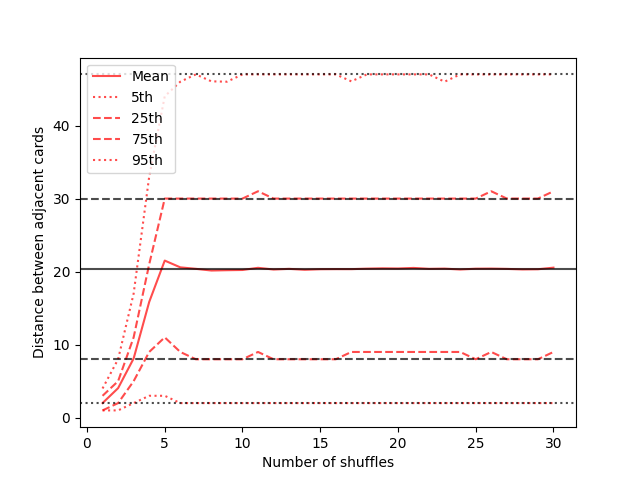

In [68]:
_ = plot_sim_summary(riffle_sim_results, ideal_stats)

It looks like it takes somewhere between 5 and 8 shuffles, I would say 6-7 based on the trends of quantiles, to get a randomized distribution using the riffle shuffling method. 

My perception of riffle shuffling with physical cards is that it takes a lot more than this to actually fully shuffle the deck, and I usually shuffle dozens of times before feeling comfortable dealing out a hand. Do I not execute the riffle shuffle as simulated here? Or am I bad at recognizing randomness (as humans generally are)?

Let's turn to pile shuffling. This is something a lot of TCG players do to shuffle their cards gently. It involves dealing out cards into some number of piles, then re-assembling the piles *in a random order*. Note that dealing cards out sequentially and picking them up sequentially does not randomize the deck at all. My implementation of pile shuffling here is different than what I usually do, which is "randomly" deal cards into piles *and* randomly pick up the piles. Here I'm not randomly dealing, just randomly picking up.

In [69]:
pile_7_sim_results = simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, n_piles=7)

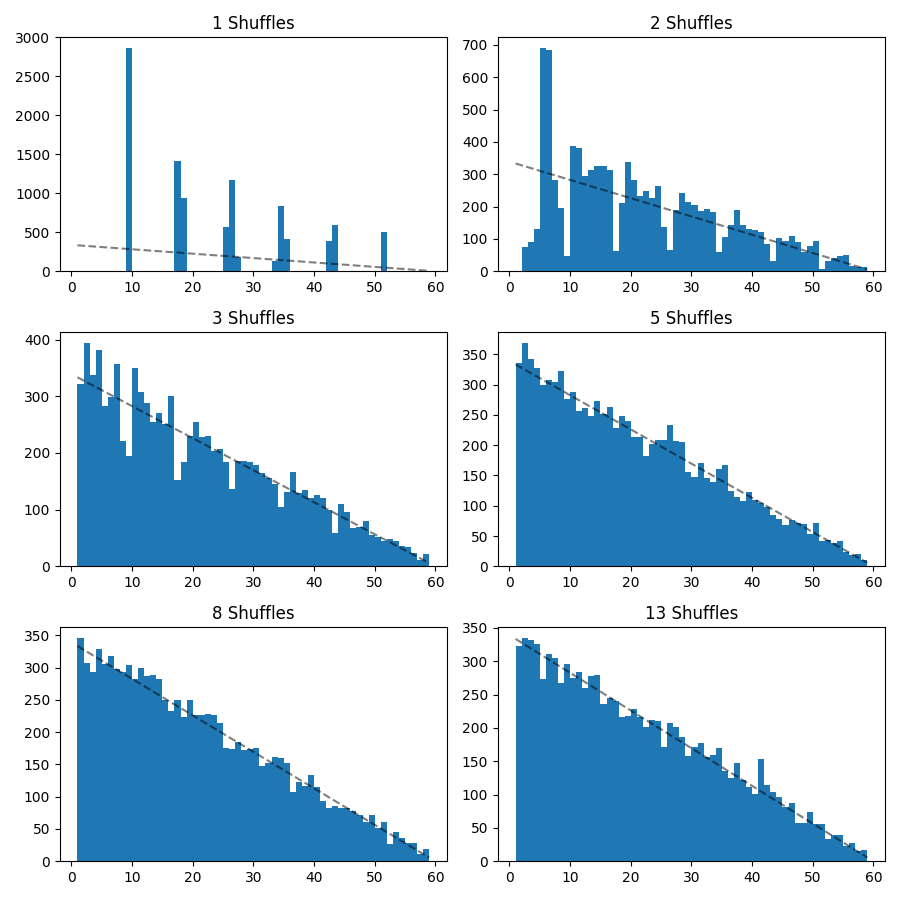

In [70]:
plot_histograms(pile_7_sim_results, x, p)

/tmp/ipykernel_1049/2446367718.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl.figure()


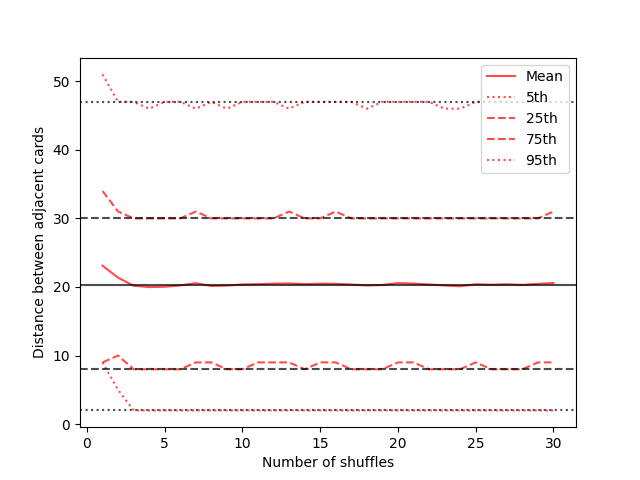

In [71]:
_ = plot_sim_summary(pile_7_sim_results, ideal_stats)

Surprisingly, this seems to achieve randomness with fewer shuffles than riffle shuffling, seemingly around 4-5 shuffles. 

Note that this result depends critically on the number of piles. Let's see what happens when we only use 3 piles.

In [73]:
pile_3_sim_results = simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, n_piles=3)

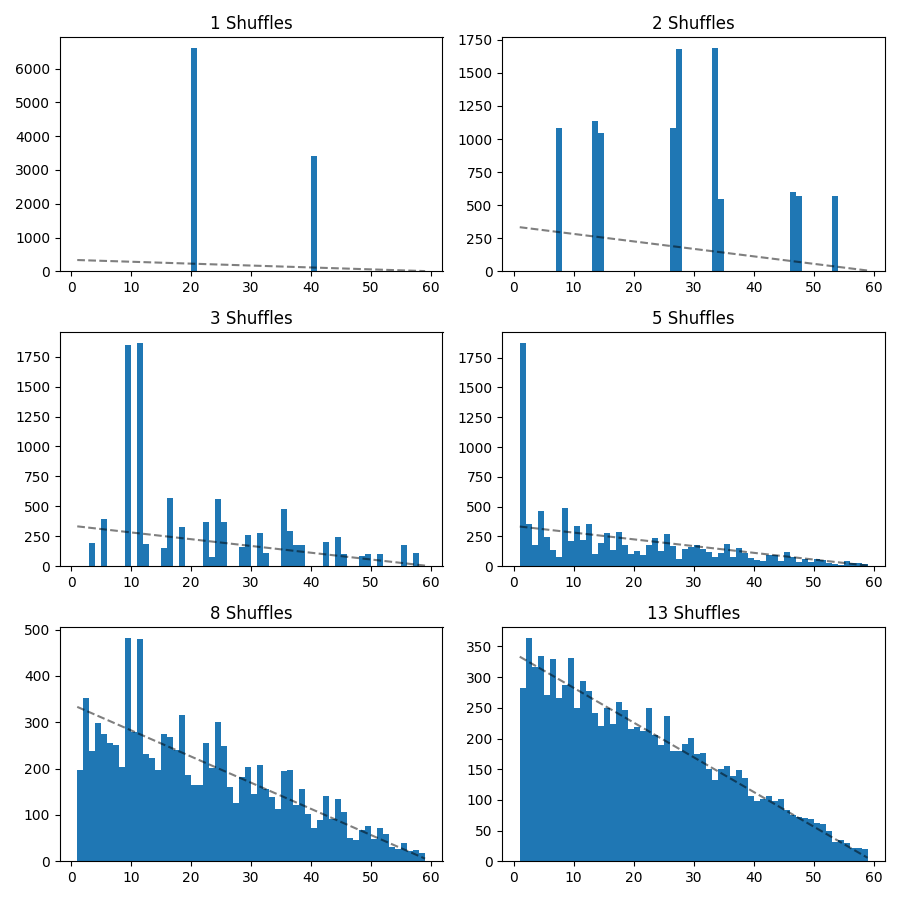

In [76]:
plot_histograms(pile_3_sim_results, x, p)

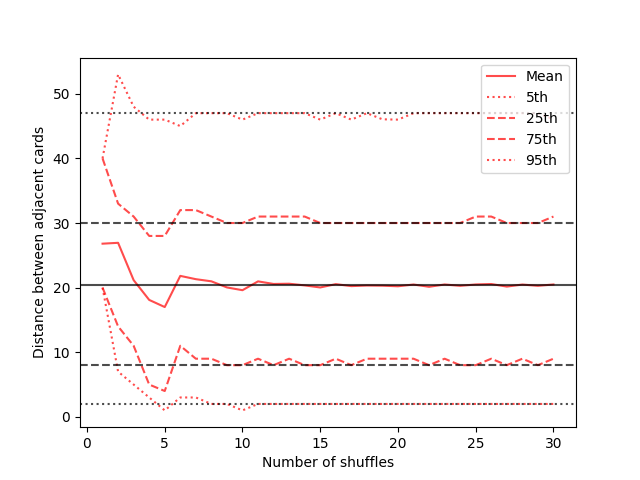

In [77]:
_ = plot_sim_summary(pile_3_sim_results, ideal_stats)

In this case we need more than 10 shuffles to get a randomized deck.

Pile shuffling gets you a result with fewer shuffles than riffle shuffling, but riffle shuffling is faster to execute so you can do more of them in the same amount of time. 

Something that I do and I see a lot of others do is do a single pile shuffle, then riffle shuffle a number of times before dealing out. Does this go faster than just riffle shuffling?

In [78]:
pile_then_riffle_sim_results = simulate_shuffling(fresh_deck, s.PileThenRiffleShuffler)

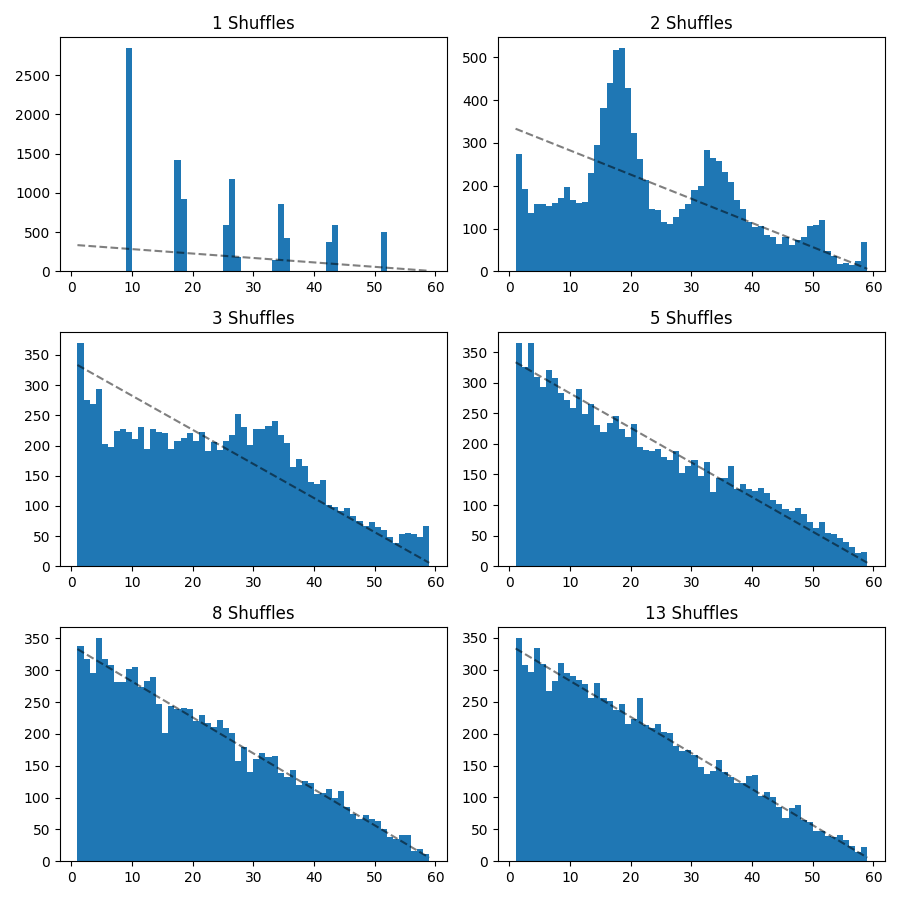

In [79]:
plot_histograms(pile_then_riffle_sim_results, x, p)

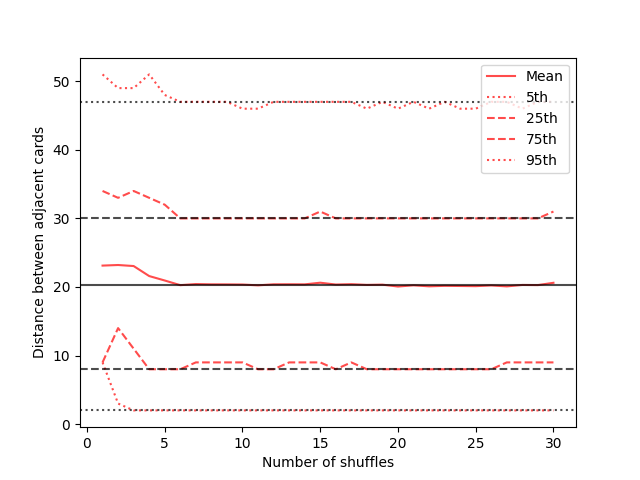

In [80]:
_ = plot_sim_summary(pile_then_riffle_sim_results, ideal_stats)

A bit, yes. It seems like we get something more like 5 shuffles (1 pile + 3-4 riffle) compared to 6-7 shuffles for pure riffle shuffling. This is the same number of shuffles as pile shuffling, but riffle shuffling is faster, so this might be the fastest approach? 


In [81]:
riffle_sim_results_mid = simulate_shuffling(fresh_deck, s.RiffleShuffler, marked_card=29)

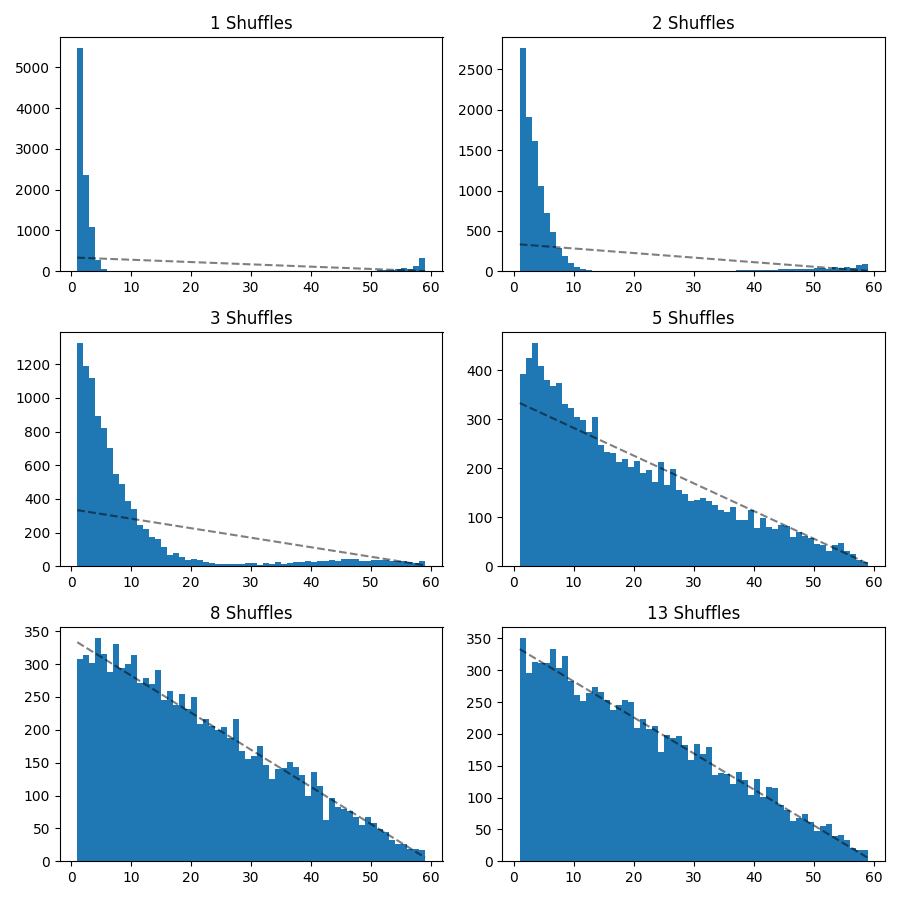

In [82]:
plot_histograms(riffle_sim_results_mid, x, p)

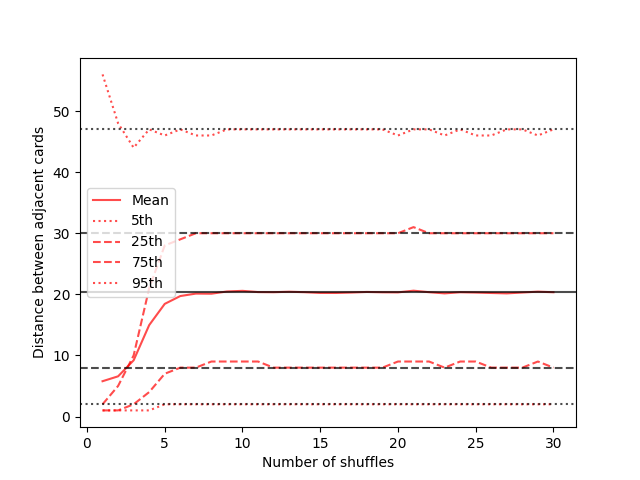

In [84]:
_ = plot_sim_summary(riffle_sim_results_mid, ideal_sim_results)

In [87]:
pile_sim_results_mid = simulate_shuffling(fresh_deck, s.RandomPickupPileShuffler, marked_card=29)

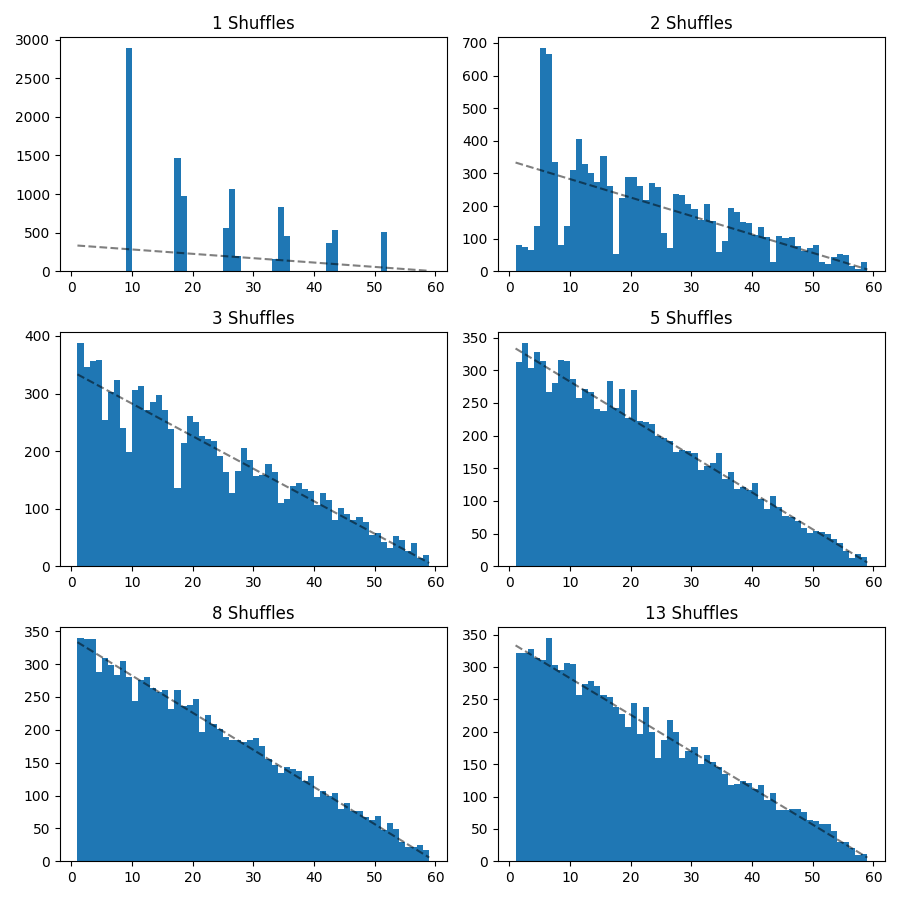

In [88]:
plot_histograms(pile_sim_results_mid, x, p)

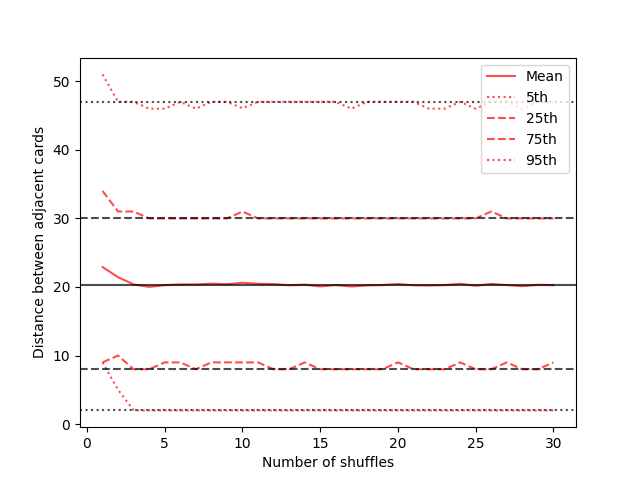

In [89]:
_ = plot_sim_summary(pile_sim_results_mid, ideal_sim_results)

- How do results compare for different marked cards? Is adjacent card distance the right way to measure randomness?
    - They are different for sure, at least for riffle shuffling. It seems to take one more shuffle to get fully randomized compared to two adjacent cards at the edge of the deck initially.
- How do the parameters (overlap, distribution of interleaved card count, etc.) for riffle shuffling impact results?
- How does physical shuffling compare to these results?
- Can I compute a metric to tell me when I'm perfectly shuffled?

In [125]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

In [126]:
def get_dist(d):
    test, _ = np.histogram(d, np.arange(1, 61))
    return test / np.sum(test)

In [ ]:
def get_kl_divs(result_set):
    kl_divs = []
    for k in result_set:
        this_dist = get_dist(result_set[k])
        kl_divs.append(kl_divergence(this_dist, p))
    return kl_divs

In [139]:
ideal_kl_divs = get_kl_divs(ideal_sim_results)

/tmp/ipykernel_1049/1126516936.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(p * np.log(p / q))
/tmp/ipykernel_1049/1126516936.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(p * np.log(p / q))


In [137]:
print(f"{np.mean(ideal_kl_divs)} +- {np.std(ideal_kl_divs) * 2}")

nan +- nan


In [129]:
riffle_sim_dists = []
riffle_kl_divs = []
for k in riffle_sim_results:
    this_dist = get_dist(riffle_sim_results[k])
    riffle_sim_dists.append(this_dist)
    riffle_kl_divs.append(kl_divergence(this_dist, p))

/tmp/ipykernel_1049/1126516936.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(p * np.log(p / q))
/tmp/ipykernel_1049/1126516936.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(p * np.log(p / q))


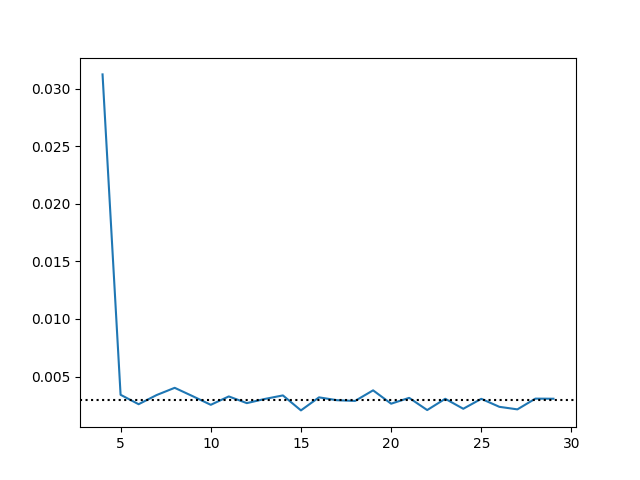

In [134]:
pl.figure()
pl.subplot(131)
pl.plot(riffle_kl_divs)
pl.axhline(np.mean(ideal_kl_divs), ls=':', c='k')
pl.subplot(131)
pl.plot(riffle_kl_divs)
pl.axhline(np.mean(ideal_kl_divs), ls=':', c='k')